In [188]:
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from pathlib2 import Path
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
from skimage.morphology import convex_hull_image

In [9]:
original_image_dir = Path('original_images/')
modified_image_dir = Path('modified_images/')

original_image_paths = list(original_image_dir.glob('*.png'))
modified_image_paths = list(modified_image_dir.glob('*.png'))

print 'original {}, modified {}'.format(len(original_image_paths), 
                                        len(modified_image_paths))

original 1788, modified 1788


In [16]:
blah = cv2.imread(str(rotated_image_name))
blah.shape

(357, 500, 3)

In [22]:
# image statistics
def image_info(filepath):
    image = cv2.imread(str(filepath))
    height, width, channels = image.shape
    
    return {'filename':str(filepath), 
            'height': height, 
            'width': width,
            'channels': channels}


original_dimensions = pd.DataFrame([image_info(f) for f in original_image_paths])
modified_dimensions = pd.DataFrame([image_info(f) for f in modified_image_paths])

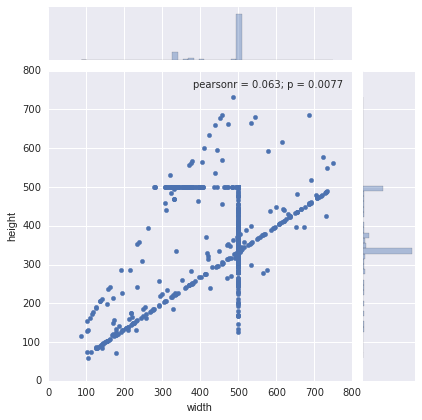

In [28]:
sns.jointplot(data=modified_dimensions, x='width', y='height')

In [40]:
# before we get into this, let's try a perceptual hash
import imagehash

original_hashes_a = {imagehash.average_hash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_a = {imagehash.average_hash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_p = {imagehash.phash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_p = {imagehash.phash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_d = {imagehash.dhash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_d = {imagehash.dhash(Image.open(str(f))): f for f in modified_image_paths}

original_hashes_w = {imagehash.whash(Image.open(str(f))): f for f in original_image_paths}
modified_hashes_w = {imagehash.whash(Image.open(str(f))): f for f in modified_image_paths}

In [43]:
# iterate through ohashes, trying to match
def match(ohash, mhash):
    unpaired = []
    for h, f in ohash.iteritems():
        if h not in mhash.keys():
            unpaired.append(f)

    print(len(unpaired))
    

print 'a'
match(original_hashes_a, modified_hashes_a)
print 'p'
match(original_hashes_p, modified_hashes_p)
print 'w'
match(original_hashes_w, modified_hashes_w)
print 'd'
match(original_hashes_d, modified_hashes_d)

a
1201
p
1229
w
1141
d
1275


Types of transforms

- blur
- rotate
    - all the rotations don't pad the boundary with anything, fit a minimal area rectangle to everything non-black should get them
- color transform (-> gray, -> weird)

preprocessing pipeline
- grayscale (undo color transforms)
- rectify (undo rotations pt 1)
- optionally, rotate right to make landscape
- center crop (by percentage) (undo rotations pt 2)
- blur and downsample to minimal size (32 x 32)

calculate rmse pairwise across dataset

In [ ]:
rotated_image_name = Path('./modified_images/fe6c006d-655b-4f69-b7d8-c8063df3d2d3.png')
gray_image_name = Path('./modified_images/fe984cbe-8906-46eb-b4d2-c6000836fbb2.png')

image_1 = Path('./modified_images/90ff1040-9b89-4d38-882b-09466867266f.png')
image_2 = Path('./oritinal

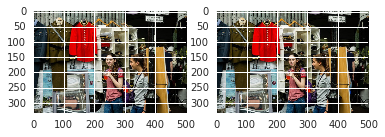

In [260]:
rotated_image_name = Path('./modified_images/fe6c006d-655b-4f69-b7d8-c8063df3d2d3.png')
gray_image_name = Path('./modified_images/fe984cbe-8906-46eb-b4d2-c6000836fbb2.png')

modified = Path('./modified_images/90ff1040-9b89-4d38-882b-09466867266f.png')
original = Path('./original_images/26940450475_1e16103e28_h.png')


plt.subplot(121)
plt.imshow(Image.open(str(original)))
plt.subplot(122)
plt.imshow(Image.open(str(modified)))

orb = cv2.ORB()
                          
def orb_features(image_path, orb, blur=False):
    image = cv2.imread(str(image_path))
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if blur:
        gray = cv2.GaussianBlur(gray, (11, 11), sigmaX=0)
                          
    kp, des = orb.detectAndCompute(gray, None)
    
#     test = cv2.drawKeypoints(gray, kp, color=(0, 255, 0))
    
#     plt.

    return kp, des
    
index_params = {
    'algorithm':6,
    'trees':5
}

search_params = {
    'checks': 50
}


flann = cv2.FlannBasedMatcher(index_params, search_params)

def match_quality(im1, im2, orb, flann):

    kp1, des1 = orb_features(im1, orb, blur=True)
    kp2, des2 = orb_features(im2, orb, blur=True)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = 0.
    for i, m in enumerate(matches):
        if len(m) < 2:
            good_matches += 1
            continue
        if m[0].distance < 0.7*m[1].distance:
            good_matches += 1


    match_quality = good_matches / len(matches)
    return match_quality

match_quality(ori)
# draw_params = dict(matchColor = (0,255,0),
#                    singlePointColor = (255,0,0),
#                    matchesMask = matchesMask,
#                    flags = 0)

# img3 = cv2.d(img1,kp1,img2,kp2,matches,None,**draw_params)
# plt.figure()
# plt.imshow(img3,),plt.show()
